In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/credit-risk/credit_risk_dataset.csv


In [179]:
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
original = pd.read_csv('/kaggle/input/credit-risk/credit_risk_dataset.csv')

In [180]:
print(train.shape)
print(test.shape)
print(original.shape)

(58645, 13)
(39098, 12)
(32581, 12)


In [181]:
train.loan_status.value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [182]:
original.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# **Join two datasets**

In [183]:
# concatenate train and original datasets and explore data

train_origin = pd.concat([train, original], axis=0, ignore_index=True)
train_origin.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0.0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1.0,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2.0,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3.0,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4.0,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [184]:
train_origin['loan_status'].value_counts()

loan_status
0    75768
1    15458
Name: count, dtype: int64

In [185]:
imbalanced_ratio = train_origin['loan_status'].value_counts()[1] / train_origin['loan_status'].value_counts()[0]
imbalanced_ratio

0.20401752718825888

The imbalanced ratio of approximately 0.204 indicates that the dataset has a imbalance between the two classes of loan status. The model may face some challenges in accurately predicting the minority class.

In [191]:
# drop id column, it is uneccessery column
train_origin = train_origin.drop('id', axis=1)

In [88]:
train_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91226 entries, 0 to 91225
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.4+ MB


In [117]:
train_origin.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,91226.000000,9.122600e+04,90331.000000,91226.000000,88110.000000,91226.000000,91226.000000,91226.000000
mean,27.616480,6.477071e+04,4.732119,9350.348607,10.789508,0.163154,5.810219,0.169447
std,6.148115,4.793696e+04,4.025068,5848.605423,3.108998,0.097491,4.038412,0.375149
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.950000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.110000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


Some applicants as old as 144, indicating potential outliers or data inaccuracies. The same with employment length.

In [118]:
train_origin.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,91226,91226,91226,91226
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,47040,18724,31761,76779


In [187]:
train_origin.duplicated().sum()

165

In [188]:
train_origin.drop_duplicates(inplace=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

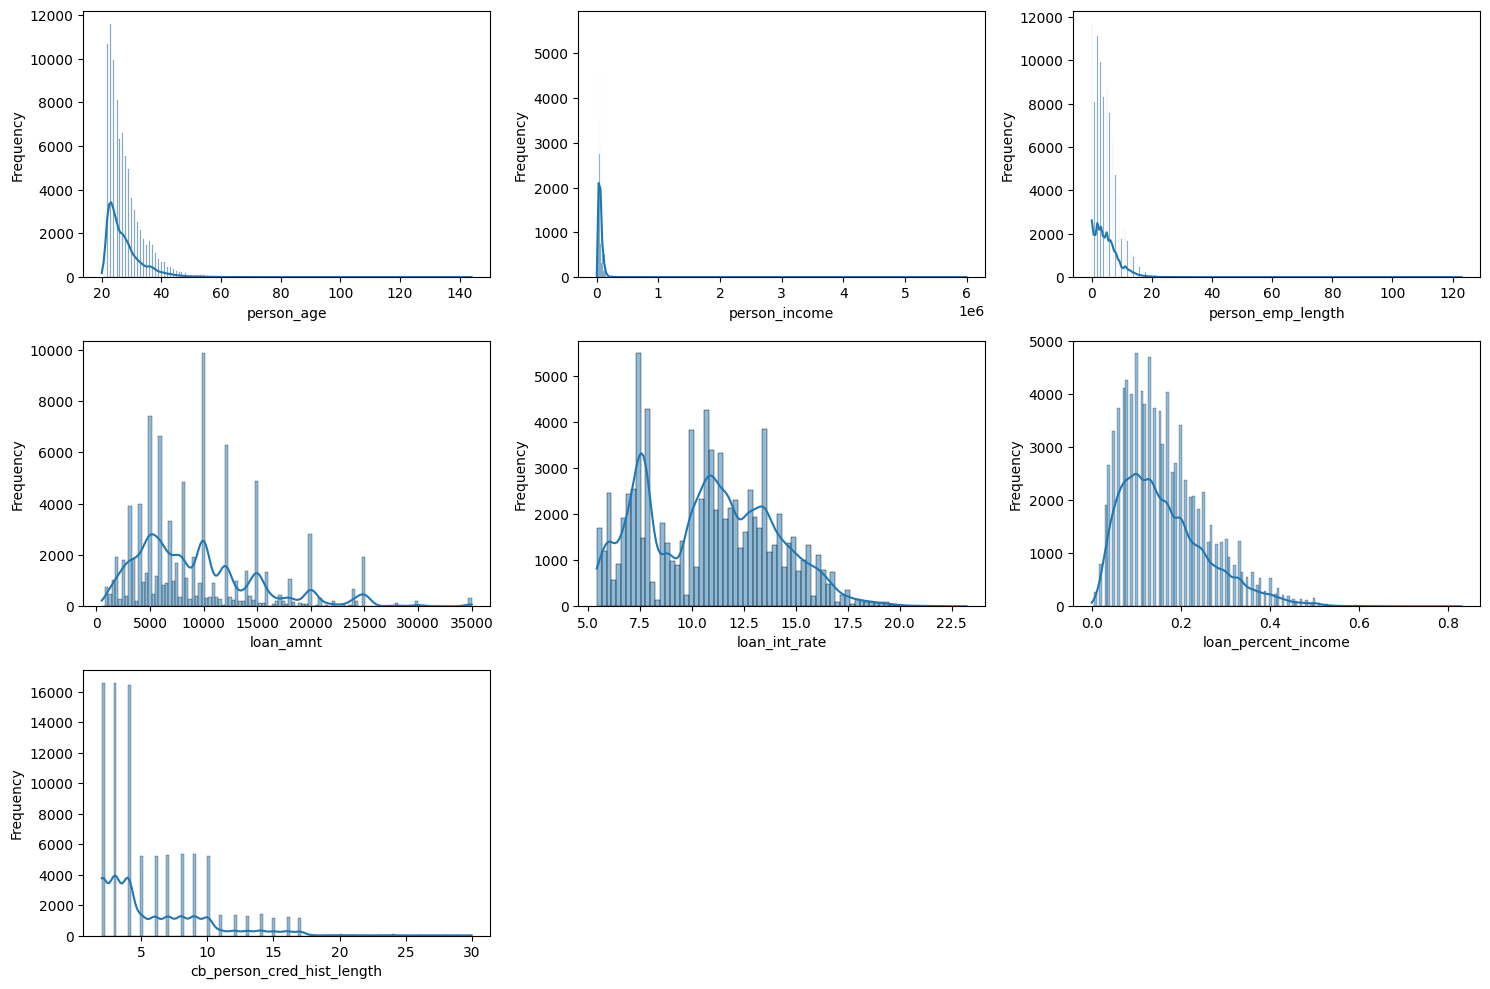

In [192]:
numerical_features = train_origin.select_dtypes(include=['number'])

plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features.iloc[:, :-1], 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_origin[feature], kde=True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

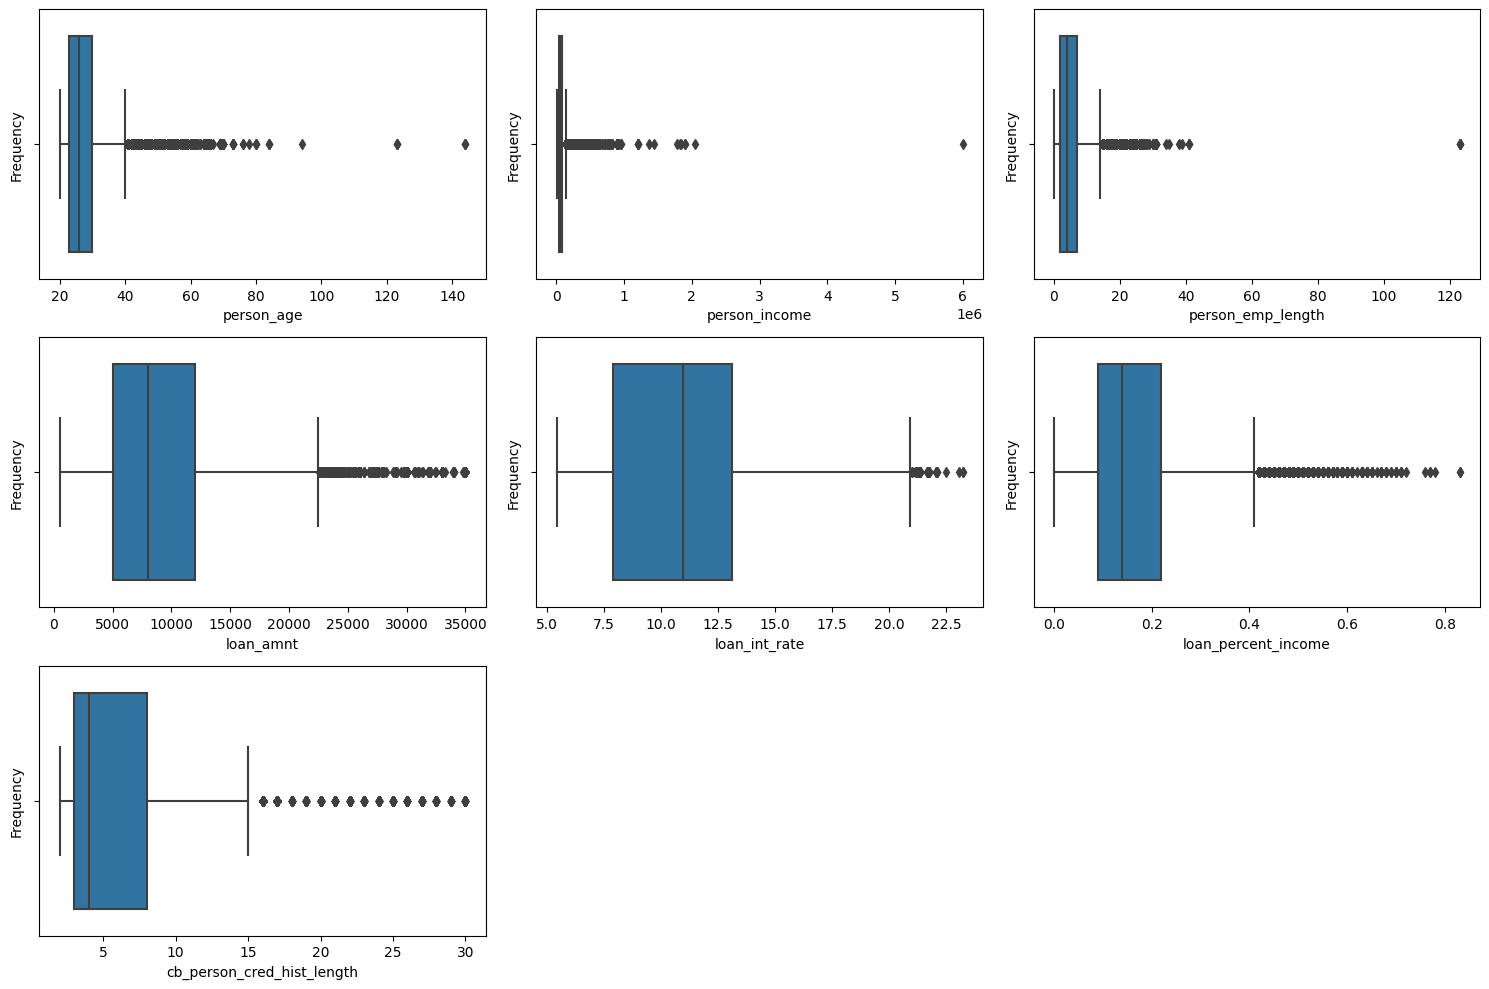

In [193]:
numerical_features = train_origin.select_dtypes(include=['number'])

plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features.iloc[:, :-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train_origin[feature])
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

In [194]:
train_origin[train_origin['person_age'] == 20]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
8925,20,38400,MORTGAGE,5.0,EDUCATION,A,15000,8.90,0.40,N,2,0
9688,20,127000,MORTGAGE,2.0,DEBTCONSOLIDATION,D,24250,15.31,0.19,N,4,1
10525,20,120000,MORTGAGE,4.0,MEDICAL,B,2500,9.99,0.02,N,4,0
11976,20,95950,RENT,2.0,EDUCATION,D,28250,14.54,0.27,N,4,1
22043,20,59000,RENT,1.0,PERSONAL,B,16800,12.42,0.29,N,2,1
36203,20,88000,MORTGAGE,4.0,EDUCATION,B,9925,10.99,0.11,N,4,0
40496,20,80000,RENT,4.0,VENTURE,C,7000,15.96,0.09,Y,2,0
41882,20,96000,RENT,3.0,MEDICAL,C,16000,13.85,0.17,N,2,0
44496,20,38000,RENT,1.0,EDUCATION,A,3200,7.68,0.08,N,4,0
49608,20,95004,MORTGAGE,4.0,EDUCATION,B,24250,10.75,0.26,N,3,0


In [195]:
# List of columns to process
columns_to_process = ['person_age', 'person_income', 'person_emp_length']

# Define percentile limits
lower_percentile = 0.005  # Adjust this value based on your data
upper_percentile = 0.995

# Loop through each column
for column in columns_to_process:
    # Calculate the lower and upper percentile limits
    lower_limit = train_origin[column].quantile(lower_percentile)
    upper_limit = train_origin[column].quantile(upper_percentile)

    print(f"Lower limit for {column}: {lower_limit}")
    print(f"Upper limit for {column}: {upper_limit}")

    # Cap the outliers
    train_origin[column] = train_origin[column].clip(lower=lower_limit, upper=upper_limit)


Lower limit for person_age: 21.0
Upper limit for person_age: 54.0
Lower limit for person_income: 14400.0
Upper limit for person_income: 240000.0
Lower limit for person_emp_length: 0.0
Upper limit for person_emp_length: 19.0


In [196]:
train_origin['loan_percent_income'].min()

0.0

<Axes: xlabel='loan_percent_income'>

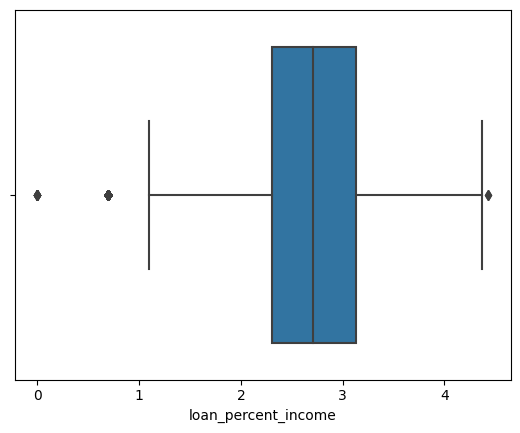

In [197]:
sns.boxplot(x = np.log1p(train_origin['loan_percent_income']*100))

<Axes: xlabel='person_emp_length'>

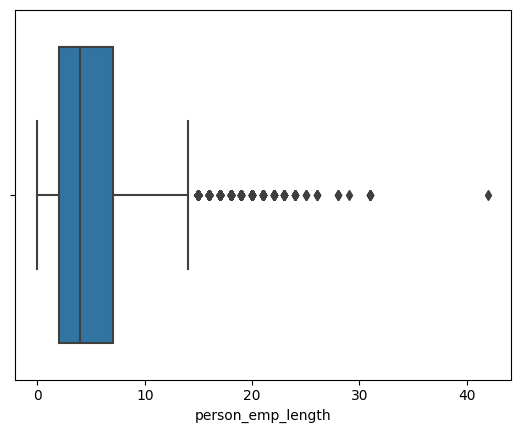

In [198]:
sns.boxplot(x = test['person_emp_length'])

In [199]:
numerical_features.corrwith(numerical_features.loan_status).abs().sort_values(ascending=False)[1:]

loan_percent_income           0.381796
loan_int_rate                 0.340284
person_income                 0.152274
loan_amnt                     0.130557
person_emp_length             0.091844
person_age                    0.008374
cb_person_cred_hist_length    0.008339
dtype: float64

<Axes: >

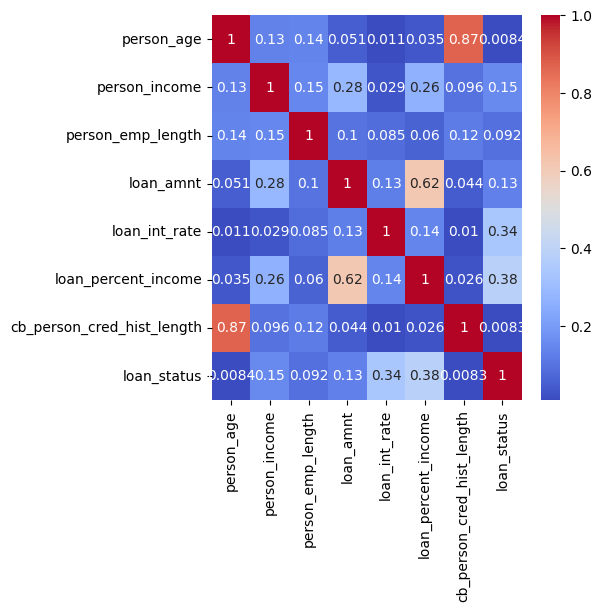

In [200]:
plt.figure(figsize=(5, 5))
corr_data = numerical_features.corr().abs()
sns.heatmap(corr_data, annot=True, cmap='coolwarm')

**High correlation between person_age and cb_person_cred_hist_length:**
There is a strong positive correlation (0.87) between person_age and cb_person_cred_hist_length. This makes sense as the length of a person’s credit history is likely to increase with age.

**Moderate correlations involving loan_percent_income:**
loan_percent_income has a moderate positive correlation (0.62) with loan_amnt, indicating that higher loan amounts often represent a higher percentage of a person's income.

In [201]:
categorical_features = train_origin.select_dtypes(include=['object'])
res = {}
for column in categorical_features.columns:
    res[column] = categorical_features[column].unique()
res

{'person_home_ownership': array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object),
 'loan_intent': array(['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION',
        'HOMEIMPROVEMENT'], dtype=object),
 'loan_grade': array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object),
 'cb_person_default_on_file': array(['N', 'Y'], dtype=object)}

In [202]:
loan_grade_group = train_origin.groupby(['loan_grade'])['loan_status'].agg(['count', 'mean'])
loan_grade_group

,count,mean
loan_grade,,
A,31687,0.066210
B,30787,0.122844
C,17474,0.161955
D,8654,0.592327
E,1972,0.634888
F,390,0.669231
G,97,0.927835


97 persons  with grade 'G' has 92% of loan_staus (1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='loan_grade', ylabel='Count'>

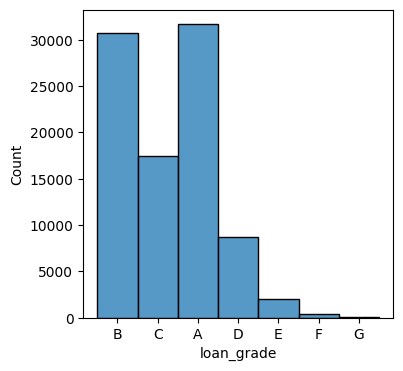

In [203]:
plt.figure(figsize=(4, 4))
sns.histplot(train_origin['loan_grade'])

In [204]:
loan_intent_group = train_origin.groupby(['loan_intent'])['loan_status'].agg(['count', 'mean'])
loan_intent_group

,count,mean
loan_intent,,
DEBTCONSOLIDATION,14322,0.224619
EDUCATION,18682,0.129965
HOMEIMPROVEMENT,9874,0.205692
MEDICAL,16976,0.210061
PERSONAL,15514,0.156246
VENTURE,15693,0.112980


In [205]:
person_home_ownership_group = train_origin.groupby(['person_home_ownership'])['loan_status'].agg(['count', 'mean'])
person_home_ownership_group

,count,mean
person_home_ownership,,
MORTGAGE,38193,0.083000
OTHER,195,0.246154
OWN,5701,0.041221
RENT,46972,0.255173


The majority of borrowers fall into the "RENT" category (47,040), followed by "MORTGAGE" (38,268), "OWN" (5,722), and a small number in "OTHER" (196). This distribution suggests that a large segment of the loan applicants are renting their homes.

In [206]:
cb_person_default_on_file_group = train_origin.groupby(['cb_person_default_on_file'])['loan_status'].agg(['count', 'mean'])
cb_person_default_on_file_group

,count,mean
cb_person_default_on_file,,
N,76629,0.139216
Y,14432,0.330585


The majority of borrowers in the dataset do not have a default on file, with 76,779 individuals in the "N" (No) category, compared to 14,447 in the "Y" (Yes) category. This suggests that a significant portion of the applicants have a clean credit history.

In [207]:
# all persons older then 80 have loan_status (0)
train_origin[train_origin['person_age'] > 80]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status


In [208]:
# drop persons with age more then 80
train_origin = train_origin.drop(train_origin[train_origin['person_age'] > 80].index)

<Axes: >

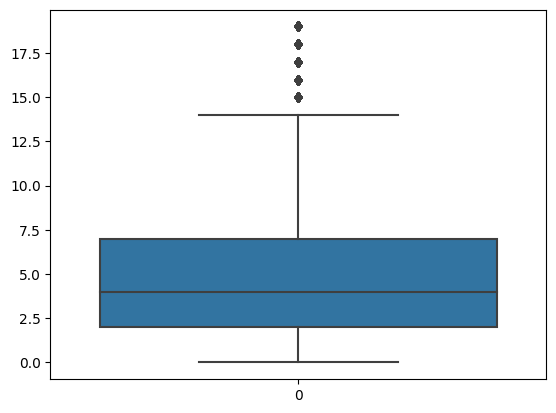

In [209]:
sns.boxplot(train_origin['person_emp_length'])

In [210]:
train_origin[(train_origin['person_emp_length'] > 30) & (train_origin['person_age'] < 50)]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status


The employment length of 123 years for individuals aged 21 to 28 is clearly unrealistic, suggesting data entry errors or anomalies and some clients have difference between age and length of the employment less then 18 year

In [211]:
train_origin[(train_origin['loan_status'] == 0) & (train_origin['person_age'] - train_origin['person_emp_length'] < 0)]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status


In [212]:
indices_to_drop = train_origin.index[(train_origin['loan_status'] == 0) & 
                                      (train_origin['person_age'] - train_origin['person_emp_length'] < 0)]
train_origin = train_origin.drop(indices_to_drop)

In [213]:
train_origin[train_origin['person_emp_length'] == 123]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status


In [ ]:
median_emp_length_22 = train_origin[train_origin['person_age']== 22]['person_emp_length'].median()
# Replace person_emp_length with the median value for age 22
train_origin.loc[train_origin['person_age'] == 22, 'person_emp_length'] = median_emp_length_22

median_emp_length_28 = train_origin[train_origin['person_age']== 28]['person_emp_length'].median()
# Replace person_emp_length with the median value for age 28
train_origin.loc[train_origin['person_age'] == 28, 'person_emp_length'] = median_emp_length_28

In [214]:
# treshhold to separate train_df and test_df
limit = train_origin.shape[0]
limit

91061

In [215]:
test = test.drop('id', axis=1)

In [216]:
df = pd.concat([train_origin, test], axis=0, ignore_index=True)

In [217]:
df.shape

(130159, 12)

In [218]:
100 * (train_origin.isna().sum()/len(test)).sort_values(ascending=False)

loan_int_rate                 7.916006
person_emp_length             2.268658
person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
loan_status                   0.000000
dtype: float64

**Fill missing values, with median**

In [219]:
df['person_emp_length']  = df['person_emp_length'].fillna(df['person_emp_length'].median())
df['loan_int_rate']  = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

In [220]:
df.isna().sum()

person_age                        0
person_income                     0
person_home_ownership             0
person_emp_length                 0
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_int_rate                     0
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0
loan_status                   39098
dtype: int64

**Create new additional feature**

In [221]:
#Debt-to-Income Ratio
df['dti'] = df['loan_amnt'] / df['person_income']

#Employment Stability
df['emp_stability'] = df['person_emp_length'].apply(lambda x: 1 if x > 5 else 0)

#Home Ownership Binary Feature
def cred_hist_category(cred_hist_length):
    if cred_hist_length < 5:
        return 'short_history'
    elif 5 <= cred_hist_length <= 10:
        return 'medium_history'
    else:
        return 'long_history'

df['cred_hist_category'] = df['cb_person_cred_hist_length'].apply(cred_hist_category)


In [ ]:
df.head(3)

In [222]:
#df_encoded = pd.get_dummies(df, drop_first=True, dtype='int')
loan_grade_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
cb_person_default_on_file_dict = {'N': 0, 'Y':1}
cred_hist_category_dict = {'long_history': 0, 'medium_history': 1, 'short_history': 2}
person_home_ownership_dict = {'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}
loan_intent_dict = {'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}

df['loan_grade'] = df['loan_grade'].map(loan_grade_dict)
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map(cb_person_default_on_file_dict)
df['person_home_ownership'] = df['person_home_ownership'].map(person_home_ownership_dict)
df['loan_intent'] = df['loan_intent'].map(loan_intent_dict)
df['cred_hist_category'] = df['cred_hist_category'].map(cred_hist_category_dict)

In [223]:
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,dti,emp_stability,cred_hist_category
0,37,35000,0,0.0,0,1,6000,11.49,0.17,0,14,0.0,0.171429,0,0
1,22,56000,2,6.0,1,2,4000,13.35,0.07,0,2,0.0,0.071429,1,2
2,29,28800,2,8.0,2,0,6000,8.90,0.21,0,10,0.0,0.208333,1,1


In [237]:
train_df = df.iloc[:limit, :]
test_df = df.iloc[limit:, :]

In [238]:
train_df.shape

(91061, 15)

In [239]:
y = train_df['loan_status']
X = train_df.drop('loan_status', axis=1)

**RandomForestClassifier**

In [227]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=1)  # 5-fold cross-validation

# Model to train
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)


# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_rf.fit(X_train, y_train)
    
    # Get predicted probabilities for the positive class
    y_prob = model_rf.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


0.9384753886010362
0.936762236732552
0.936205648161725
0.9378907465127657
0.9402595602603966
Average AUC: 0.9379


**XGBoostClassifier**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=1)  # 5-fold cross-validation

# Model to train
model_xgb = xgb.XGBClassifier(
    scale_pos_weight=4,  # Adjust this based on imbalance ratio
    use_label_encoder=False,  # Avoids label encoding warning
    eval_metric='auc',  # Use AUC as the evaluation metric
    random_state=42
)


# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_xgb.fit(X_train, y_train)
    
    # Get predicted probabilities for the positive class
    y_prob = model_xgb.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


**CatBoostClassifier**

In [241]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=1)  # 5-fold cross-validation

# Model to train
model_cat = CatBoostClassifier(
    iterations=1000,             # Number of boosting iterations
    learning_rate=0.1,           # Learning rate
    depth=4,                     # Depth of the trees
    class_weights=[1, 3],        # Adjust class weights (example: 1 for majority, 4 for minority)
    eval_metric='AUC',           # Use AUC as the evaluation metric
    random_seed=42,
    verbose=100                  # Print progress every 100 iterations
)

# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_cat.fit(X_train, y_train, verbose=False)
    
    # Get predicted probabilities for the positive class
    y_prob = model_cat.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


0.9631567678670834
0.9610703162020415
0.9564746840625269
0.9586158781705088
0.9590746932439673
Average AUC: 0.9597


**LGBMClassifier**

In [257]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)  # 5-fold cross-validation

# Model to train
model_lgb = lgb.LGBMClassifier(
    n_estimators=1000,            # Number of boosting iterations
    learning_rate=0.08195180816746779,            # Learning rate
    max_depth=4,                  # Depth of the trees
    class_weight='balanced',      # Automatically adjust weights for class imbalance
    random_state=1,
    verbose=-1
)

# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_lgb.fit(X_train, y_train)
    
    # Get predicted probabilities for the positive class
    y_prob = model_lgb.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


0.9640981351432364
0.9611677442326794
0.9563986074358704
0.9602049011419245
0.9589683401326237
Average AUC: 0.9602


**GradientBoostingClassifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)  # 5-fold cross-validation

# Model to train
model_grb = GradientBoostingClassifier(
    n_estimators=1000,            # Number of boosting iterations
    learning_rate=0.1,            # Learning rate
    max_depth=4                 # Depth of the trees
)

# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_grb.fit(X_train, y_train)
    
    # Get predicted probabilities for the positive class
    y_prob = model_grb.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC for fold: {auc:.4f}")
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


In [244]:

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=1)  # 5-fold cross-validation

model_cat = CatBoostClassifier(
    iterations=1497,
    learning_rate=0.19862700515892123,
    depth=3,
    class_weights={0: 1, 1: 2.8609507839857535},  # Example of giving more weight to the minority class
#    cat_features=cat_features,
    border_count = 241,
    eval_metric='AUC',           # Use AUC as the evaluation metric
    random_seed=1,
    verbose=100
)

# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_cat.fit(X_train, y_train)
    
    # Get predicted probabilities for the positive class
    y_prob = model_cat.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")
#9602

0:	total: 9.58ms	remaining: 14.3s
100:	total: 1.06s	remaining: 14.7s
200:	total: 2.05s	remaining: 13.2s
300:	total: 3.02s	remaining: 12s
400:	total: 4s	remaining: 10.9s
500:	total: 4.97s	remaining: 9.87s
600:	total: 5.95s	remaining: 8.87s
700:	total: 6.93s	remaining: 7.87s
800:	total: 7.91s	remaining: 6.88s
900:	total: 8.89s	remaining: 5.88s
1000:	total: 9.9s	remaining: 4.9s
1100:	total: 10.9s	remaining: 3.93s
1200:	total: 11.9s	remaining: 2.94s
1300:	total: 12.9s	remaining: 1.94s
1400:	total: 13.9s	remaining: 951ms
1496:	total: 14.8s	remaining: 0us
0.9634027962146192
0:	total: 9.6ms	remaining: 14.4s
100:	total: 980ms	remaining: 13.6s
200:	total: 1.96s	remaining: 12.6s
300:	total: 2.94s	remaining: 11.7s
400:	total: 3.92s	remaining: 10.7s
500:	total: 4.95s	remaining: 9.84s
600:	total: 5.95s	remaining: 8.87s
700:	total: 6.92s	remaining: 7.86s
800:	total: 7.91s	remaining: 6.88s
900:	total: 8.89s	remaining: 5.88s
1000:	total: 9.88s	remaining: 4.89s
1100:	total: 10.9s	remaining: 3.91s
1200:

                       Feature  Importance
1                person_income   23.191796
8          loan_percent_income   19.457770
5                   loan_grade   14.275265
4                  loan_intent   10.947206
2        person_home_ownership   10.338798
11                         dti    7.497881
7                loan_int_rate    5.481549
3            person_emp_length    3.076085
0                   person_age    2.597158
6                    loan_amnt    2.246082
10  cb_person_cred_hist_length    0.711897
9    cb_person_default_on_file    0.072811
12               emp_stability    0.069086
13          cred_hist_category    0.036617


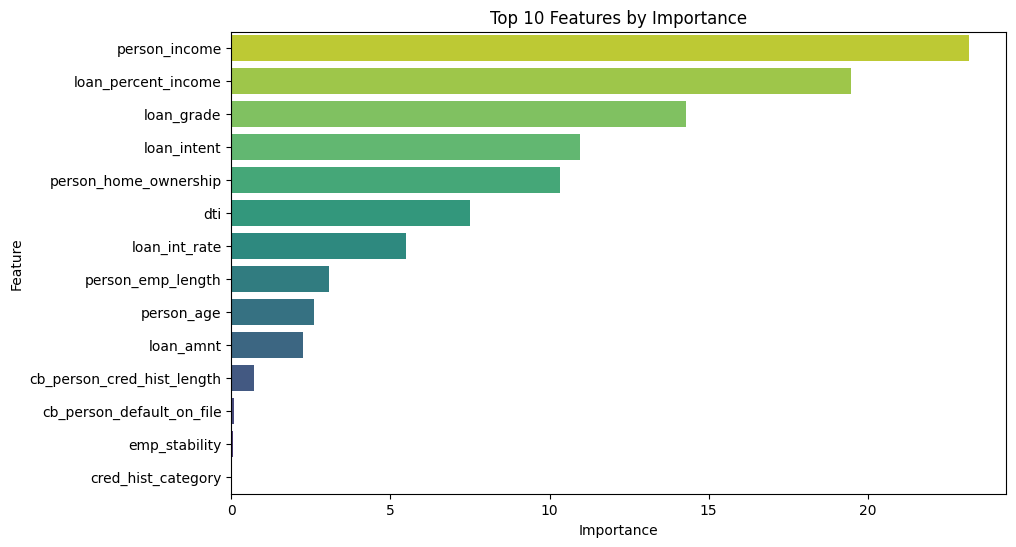

In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = model_cat.get_feature_importance()

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=True), palette='viridis')
plt.xlabel('Importance')
plt.title('Top 10 Features by Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


In [253]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Define the objective function for Optuna
def objective(trial):
    # Only optimize the learning rate
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.7, log=True)  # Learning rate

    # Fixed parameters
    params = {
        'n_estimators': 1000,  # Number of boosting iterations
        'max_depth': 4,  # Depth of the trees
        'class_weight': 'balanced',  # Automatically adjust weights for class imbalance
        'random_state': 1,
        'verbose': -1,
        'boosting_type': 'gbdt',  # Boosting type
        #'num_leaves': 31  # Fixed number of leaves
    }

    # Define StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    auc_scores = []

    # Cross-validation process
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate, **params)
        model_lgb.fit(X_train, y_train)

        # Get predicted probabilities for the positive class
        y_prob = model_lgb.predict_proba(X_test)[:, 1]

        # Calculate AUC
        auc = roc_auc_score(y_test, y_prob)
        auc_scores.append(auc)

    # Return the average AUC score for the trials
    return sum(auc_scores) / len(auc_scores)

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # You can adjust the number of trials

# Print the best hyperparameters and the best score
print(f"Best learning rate: {study.best_params['learning_rate']:.4f}")
print(f"Best AUC score: {study.best_value:.4f}")


[I 2024-10-18 15:22:12,162] A new study created in memory with name: no-name-8557850e-95dc-4c6b-96c2-b7a4159bddaa
[I 2024-10-18 15:23:15,334] Trial 0 finished with value: 0.9553062408844808 and parameters: {'learning_rate': 0.02432440524524449}. Best is trial 0 with value: 0.9553062408844808.
[I 2024-10-18 15:24:24,868] Trial 1 finished with value: 0.9243553868176951 and parameters: {'learning_rate': 0.002827721975234173}. Best is trial 0 with value: 0.9553062408844808.
[I 2024-10-18 15:25:31,212] Trial 2 finished with value: 0.9141573599895769 and parameters: {'learning_rate': 0.0012245320339680469}. Best is trial 0 with value: 0.9553062408844808.
[I 2024-10-18 15:26:32,061] Trial 3 finished with value: 0.959244254593294 and parameters: {'learning_rate': 0.050511791570733156}. Best is trial 3 with value: 0.959244254593294.
[I 2024-10-18 15:27:39,049] Trial 4 finished with value: 0.9422177409480745 and parameters: {'learning_rate': 0.008515604318023614}. Best is trial 3 with value: 0.9

KeyboardInterrupt: 

Optuna to find best hyperparametrs of model

In [ ]:
# import pandas as pd
# import optuna
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_auc_score

# # Assuming X and y are your features and target variable
# # Define StratifiedKFold
# skf = StratifiedKFold(n_splits=5)

# # Define the objective function for Optuna
# def objective(trial):
#     # Suggest hyperparameters
#     n_estimators = trial.suggest_int('n_estimators', 50, 1000)  # Number of boosting iterations
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)  # Learning rate
#     max_depth = trial.suggest_int('max_depth', 3, 6)  # Depth of the trees
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Minimum samples to split a node
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)  # Minimum samples in leaf node

#     # Model to train
#     model_grb = GradientBoostingClassifier(
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         random_state=42
#     )

#     # List to store AUC scores
#     auc_scores = []

#     # Cross-validation process
#     for train_index, test_index in skf.split(X, y):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#         # Train the model
#         model_grb.fit(X_train, y_train)

#         # Get predicted probabilities for the positive class
#         y_prob = model_grb.predict_proba(X_test)[:, 1]

#         # Calculate AUC
#         auc = roc_auc_score(y_test, y_prob)
#         auc_scores.append(auc)

#     # Return the average AUC score across all folds
#     return sum(auc_scores) / len(auc_scores)

# # Create an Optuna study
# study = optuna.create_study(direction='maximize')  # We want to maximize AUC

# # Optimize the hyperparameters
# study.optimize(objective, n_trials=100)  # Number of trials to perform

# # Print the best hyperparameters and AUC score
# print("Best hyperparameters: ", study.best_params)
# print("Best AUC score: ", study.best_value)


In [258]:
test_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,dti,emp_stability,cred_hist_category
91061,23,69000,0,3.0,5,5,25000,15.76,0.36,0,2,0.362319,0,2
91062,26,96000,1,6.0,2,2,10000,12.68,0.10,1,4,0.104167,1,2
91063,26,30000,0,5.0,3,4,4000,17.19,0.13,1,2,0.133333,0,2
91064,33,50000,0,4.0,4,0,7000,8.90,0.14,0,7,0.140000,0,1
91065,26,102000,1,8.0,5,3,15000,16.32,0.15,1,4,0.147059,1,2


In [ ]:
test_df = test_df.drop('loan_status', axis=1)

In [260]:
test_predictions = model_lgb.predict_proba(test_df)[:, 1]

In [261]:
test_predictions

array([0.99990686, 0.09782147, 0.86200902, ..., 0.01152172, 0.65203865,
       0.98985041])

In [263]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = test_predictions
submission.to_csv('submission_1810_lgb.csv', index=False)
submission.head()

,id,loan_status
0,58645,0.999907
1,58646,0.097821
2,58647,0.862009
3,58648,0.035206
4,58649,0.212699
